<h2>중간고사: 컴퓨터 비전 문제</h2>
<h4>컴퓨터공학과 202121860 이하연</h4>

In [1]:
import torch.nn as nn # 파이토치의 신경망 모듈(nn)을 임포트
import torch # torch, torch.optim, torch.nn.functional 모듈을 임포트하는데 PyTorch에서 모델을 구성하고 최적화하는 데 필요한 함수와 클래스를 제공
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# FashionMNIST을 로드하고 설정
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 이미지를 정규화함
])

In [3]:
# FashionMNIST 훈련 및 테스트 데이터셋 다운
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
# 파이토치(PyTorch)를 사용하여 간단한 신경망 모델을 정의하고, 그 구조를 요약해서 출력하는 과정을 설명
class OneCNN(nn.Module): # nn.Module을 상속받는 OneCNN라는 새로운 클래스를 정의하는데 nn.Module은 파이토치에서 모든 신경망 모듈의 기본 클래스
    def __init__(self): # 클래스의 생성자로, OneCNN 객체가 생성될 때 초기화 과정을 정의
        super(OneCNN, self).__init__() # 상위 클래스인 nn.Module의 생성자를 호출하여 클래스를 적절히 초기화
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  # 과제 조건 중 첫 번째 컨볼루션 레이어
        self.pool = nn.MaxPool2d(2, 2)  # 과제 조건 중 풀링레이어
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)  # 두 번째 컨볼루션 레이어
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 입력 특성을 10개의 출력 특성으로 변환하는 완전 연결 레이어(또는 선형 레이어)를 정의하고, fc 속성으로 할당

    def forward(self, x): # 모델의 순전파를 정의하는 메서드로 입력 텐서 x가 모델을 통과하는 과정을 설명
        x = self.pool(F.relu(self.conv1(x)))  # 정의된 풀링 레이어를 입력 x에 적용한 후 ReLU 활성화 함수를 적용
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # ReLU의 출력을 flatten 레이어를 통해 평탄화
        x = F.relu(self.fc1(x))  # 입력 x에 적용한 후 ReLU 활성화 함수 적용
        x = self.fc2(x)  # 출력
        return x

# 초기화 진행
model = OneCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
# PyTorch를 사용하여 신경망 모델을 학습하고 검증하는 과정을 구현
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=5): # 함수를 정의하여 모델, 학습 데이터 로더, 테스트 데이터 로더, 그리고 에폭 수를 매개변수로 받음
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []} 

    # 에폭 수만큼 반복하면서 모델의 학습 및 평가를 수행하는데 학습 시에는 model.train()을 호출하여 모델을 학습 모드로 설정하고, 평가 시에는 model.eval()을 호출하여 평가 모드로 설정
    for epoch in range(epochs):
        # 모델의 학습
        model.train()
        train_loss = 0
        train_correct = 0
        total_train = 0
        
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()
            total_train += labels.size(0)
        
        # 모델의 평가
        model.eval()
        test_loss = 0
        test_correct = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item() * images.size(0) # 정확도와 손실을 기록, 진행 상황 모니터링
                _, predicted = torch.max(outputs.data, 1)
                test_correct += (predicted == labels).sum().item()
                total_test += labels.size(0)
        
        # 평균 손실과 정확도
        epoch_train_loss = train_loss / total_train
        epoch_train_acc = 100 * train_correct / total_train
        epoch_test_loss = test_loss / total_test
        epoch_test_acc = 100 * test_correct / total_test
        
        # history에 저장
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['test_loss'].append(epoch_test_loss)
        history['test_acc'].append(epoch_test_acc)
        
        print(f'Epoch {epoch + 1}/{epochs}: Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.2f}%')
    
    return history # 학습과 테스트 과정에서의 손실과 정확도를 기록한 history 딕셔너리를 반환

Epoch 1/5: Train Loss: 0.4727, Train Acc: 83.00%, Test Loss: 0.3643, Test Acc: 86.50%
Epoch 2/5: Train Loss: 0.3124, Train Acc: 88.72%, Test Loss: 0.3085, Test Acc: 88.82%
Epoch 3/5: Train Loss: 0.2644, Train Acc: 90.34%, Test Loss: 0.2725, Test Acc: 89.80%
Epoch 4/5: Train Loss: 0.2350, Train Acc: 91.32%, Test Loss: 0.2799, Test Acc: 89.62%
Epoch 5/5: Train Loss: 0.2121, Train Acc: 92.07%, Test Loss: 0.2618, Test Acc: 90.39%


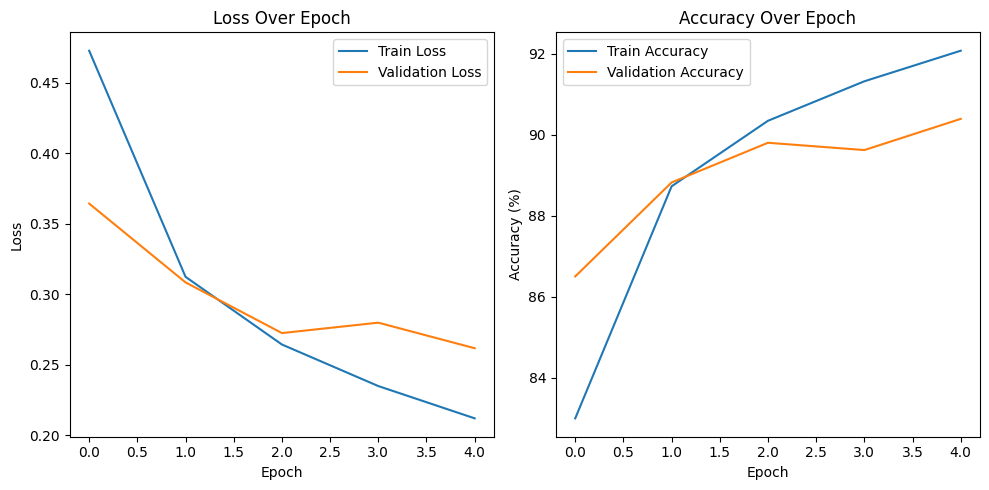

In [6]:
# 신경망 모델을 학습시키고 그 결과를 처리하는 과정을 보여줌
def plot_metrics(history):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['test_loss'], label='Validation Loss')
    plt.title('Loss Over Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['test_acc'], label='Validation Accuracy')
    plt.title('Accuracy Over Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 함수를 호출하여 신경망 모델을 학습시키는데 총 5 에폭(epoch) 동안 학습을 수행하고 학습 과정에서 계산된 손실과 정확도 같은 통계 정보를 history 변수에 저장
history = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=5)
plot_metrics(history) # plot_metrics 함수를 호출하여 history에 저장된 학습 결과 시각화